In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision.transforms import v2
from PIL import Image

In [3]:
class DeepfakeNet(nn.Module):
    def __init__(self):
        super(DeepfakeNet, self).__init__()
#         self.drp = nn.Dropout(0.4)#------------------------------------------------------------------------------------------------------------------------
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layers = nn.ModuleList([Bottleneck(64, 256, first=True)])
        self.out_size = [256,512,1024,2048]
        self.blocks = [1,2,2,1]
        for i in range(len(self.out_size)):
            if i > 0:
                self.layers.append(Bottleneck(self.out_size[i-1], self.out_size[i], 2))
            for extraLayers in range(self.blocks[i]-1):
                self.layers.append(Bottleneck(self.out_size[i], self.out_size[i]))
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, 1)



    # def _make_layer(self, in_channels, out_channels, blocks):
    #     layers = []
    #     for _ in range(blocks):
    #         layers.append(Bottleneck(in_channels, out_channels))
    #     return nn.Sequential(*layers)

    def forward(self, x):
#         x = self.drp(x)#------------------------------------------------------------------------------------------------------------------------------------
        x = self.conv1(x)
        x = self.maxpool(x)
        for layer in self.layers:
            x = layer(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [4]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, first=False):
        super(Bottleneck, self).__init__()
        mid_channels = out_channels//2
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=mid_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(in_channels=mid_channels, out_channels=mid_channels, kernel_size=3, padding=1, groups=32, stride=stride)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.conv3 = nn.Conv2d(in_channels=mid_channels, out_channels=out_channels, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = stride == 2 or first
        if self.downsample:
            self.changeInputC2D = nn.Conv2d(in_channels = in_channels, out_channels=out_channels, kernel_size=1, stride=stride)
            self.changeInputBn = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample:
            residual = self.changeInputC2D(residual)
            residual = self.changeInputBn(residual)
        out = torch.add(out, residual)
        out = self.relu(out)
        return out



In [5]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Calculate average loss
    avg_loss = running_loss / len(dataloader)
    training_loss.append(avg_loss)
    return avg_loss

In [6]:
def evaluate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Accumulate loss
            val_loss += loss.item()

            # Calculate accuracy
            predicted = torch.round(outputs)
            # print(outputs)
            # print(predicted)
            # print(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy
    avg_loss = val_loss / len(dataloader)
    accuracy = 100.0 * correct / total
    validation_loss.append(avg_loss)
    validation_acc.append(accuracy)
    return avg_loss, accuracy

In [7]:
# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [1]:
!git clone "https://github.com/Bhavnoor-Coders-1010/DeepfakeDetectionBCS"

Cloning into 'DeepfakeDetectionBCS'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 27 (delta 5), reused 3 (delta 0), pack-reused 11 (from 1)
Receiving objects: 100% (27/27), 94.10 MiB | 40.80 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [8]:
newModel = torch.load("/kaggle/working/DeepfakeDetectionBCS/DeepfakeBCSLatest.pth", weights_only=False)
newModel.to(device)

DeepfakeNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): ModuleList(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (changeInputC2D): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (changeInputBn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Bottleneck(
      (conv1): Conv2d(256, 256

REAL


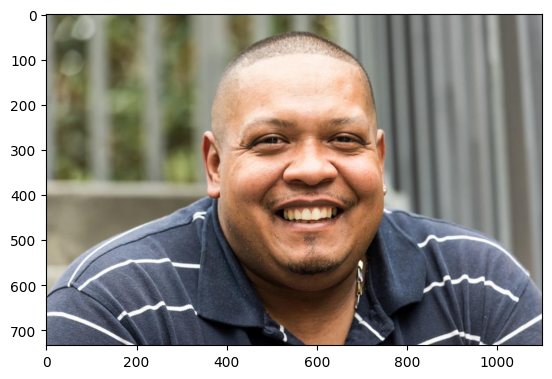

In [13]:
from PIL import Image
newModel.eval()
path = "/kaggle/input/newerimage/nice-man-smiling.jpg"
img = Image.open(path)
plt.imshow(img)
basic = v2.Compose([v2.Resize((224,224)),v2.ToTensor()])
img = basic(img)

img = img.to(device)
img = img.view((1,3,224,224))
if torch.round(newModel(img)).item()==1:
  print("FAKE")
else:
  print("REAL")

FAKE


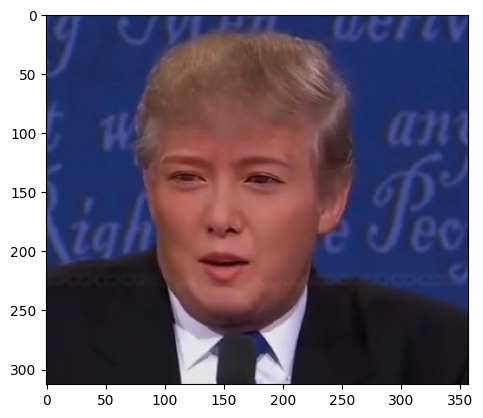

In [14]:
from PIL import Image
newModel.eval()
path = "/kaggle/input/newimage/879a99a2-1f42-4840-bc42-0662e49c2992.jpg"
img = Image.open(path)
plt.imshow(img)
basic = v2.Compose([v2.Resize((224,224)),v2.ToTensor()])
img = basic(img)

img = img.to(device)
img = img.view((1,3,224,224))
if torch.round(newModel(img)).item()==1:
  print("FAKE")
else:
  print("REAL")